### NLP_ENDOPATHS_OPENAI

Author: Nicolai Wolpert  
Email: nicolai.wolpert@capgemini.com  
October 2024


Script to test the prediction of patient symptoms using openai models. Uses the API of Capgemini's Generative Engine: https://generative.engine.capgemini.com/  
For any assistance with the API, ask the 'Avril' assistant.  

Important notes:  
- Chatgpt-4 and Chatgpt-4o are the two models tested so far. Chatgpt-4o is supposed to be more powerful, but it comes with two disadvantages:  
        1) It takes longer to generate the output (~20 seconds in contrast to ~5 seconds for Chatgpt-4)  
        2) It has a stricter character limit for the prompt, which is probably around 10,000 (unknown for Chatgpt4)
- The total number of API calls per week is 10,000 (no model which model you use, it's not a limit per model but in total). This is reached fast, since most patients have texts that need to be split into multiple parts. Therefore be careful on the usage. In this script, the model is called on a part of all the patients.
- Sometimes, the call to the API fails (Error: 504 - {"message": "Endpoint request timed out"}). This is a bit random. In this script, 5 attempts are given. Normally the API call went trough in at least one. Else it will give a warning. If this happens too frequently, there is an issue with the connection, you can try splitting the texts into smaller parts to make the prompts less heavy.

In [10]:
### Imports ###

# Data manipulation and other stuff : 
import numpy as np
import pandas as pd
import re
#pd.set_option('display.max_rows', 10)
from matplotlib import pyplot as plt
import seaborn as sns

# Utils for NLP : 
import openai
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Utils for encoding : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Utils for regression : 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight

# Utils for Metrics calculation : 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, hamming_loss, accuracy_score, jaccard_score, classification_report, roc_auc_score
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

# Custom preprocessing : 
from preprocess_NLP import *

from metrics_utils import *
from Opti_utils.ML_utils import Binarisation

# Tensorflow/keras
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.utils import to_categorical
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from keras import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense

import functools

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, f1_score

from tqdm.notebook import tqdm

from datasets.dataset_dict import DatasetDict
from datasets import Dataset

import pickle
from sklearn.model_selection import StratifiedShuffleSplit

import requests
import json
import time
import warnings

In [ ]:
target_feature = 'atcd.endo'   # 'atcd.absenteisme' / 'tv.douloureux'
model_name = 'openai.gpt-4o' # 'openai.gpt-4' / 'openai.gpt-3.5-turbo'
# Use original receuil data or infos extracted manually from the gyneco files
receuil_data = 'manual_gyneco'     # 'orig' or 'manual_gyneco'

# Loading X : 
#df_nlp = pd.read_csv('./../../Data/Generate/donnees_entree_nlp_sans_endo.csv', usecols=['Anonymisation', 'Date', 'Nature', 'Résumé'])
df_nlp = pd.read_csv('Data/DATA_PROCESSED/Donnees_avec_endo_concat.csv', usecols=['Anonymisation', 'Résumé'])
df_nlp_orig = df_nlp.copy()
print('X shape is :', df_nlp.shape)

# Loading Y :
if receuil_data == 'manual_gyneco':
    # Read the receuil version created by manually extracting infos from gyneco files
    recueil = pd.read_excel('Data/DATA_PROCESSED/data_gynéco_manual_extraction.xlsx')
    recueil = recueil[['Anonymisation'] + [target_feature]]

else:
    recueil_orig  = pd.read_excel('Data/DATA_RAW/Recueil (1).xlsx').drop('Unnamed: 90', axis=1)
    recueil = recueil_orig.copy()
    recueil = recueil[['Numéro anonymat', 'atcd.endo', 'irm.lusg', 'tv.douloureux', 'irm.externe', 'sf.dig.diarrhee', 'echo.lusg', 'echo.lusd', 'ef.hormone.dpc', 'effet.hormone']]
    recueil.replace(['Na', 'NA'], np.nan, inplace=True)
    recueil = recueil.rename(columns={'Numéro anonymat': 'Anonymisation'})
    # Note the target variable, if endometriosis is present or not (corresponds to the anapth columns but not 'autre')
    recueil['endometriose'] = recueil_orig.loc[:,['anapath.lusd','anapath.lusg','anapath.torus']].sum(axis=1).apply(lambda x: Binarisation(x))
    # Drop the anapath columns again
    recueil = recueil[[c for c in recueil.columns if not c.startswith('anapath')]]
    recueil = recueil[['Anonymisation'] + [target_feature]]

print('Y shape is :', recueil.shape)
print(f'Nombre de patientes dans le df_nlp : {len(df_nlp.Anonymisation.unique())}')
print(f'Nombre de patientes dans le recueil : {len(recueil.Anonymisation.unique())}')
npatients_in_gyneco_and_receuil = len(set(df_nlp.Anonymisation.unique()).intersection(set(recueil.Anonymisation.unique())))
print(f'Nombre de patientes dans gyneco et recueil : {npatients_in_gyneco_and_receuil}')
num_labels = len(pd.unique(recueil[target_feature]))
print(f'Nombre de classes pour {target_feature}: {num_labels}')

if 'DJ-055' in list(df_nlp['Anonymisation']):
    df_nlp.loc[df_nlp['Anonymisation']=='DJ-055', 'Anonymisation'] ='NJ-055'
'NJ-055' in list(df_nlp['Anonymisation'])
'DJ-055' in list(df_nlp['Anonymisation'])

X shape is : (200, 2)
Y shape is : (176, 2)
Nombre de patientes dans le df_nlp : 200
Nombre de patientes dans le recueil : 176
Nombre de patientes dans gyneco et recueil : 176
Nombre de classes pour atcd.endo: 3


False

## Preprocessing

In [12]:
# IMPORTANT: Lowercase and removal of special characters has to be applied before 'correction_series', else words will not be found in the correction dictionnary
df_nlp.Résumé = df_nlp.Résumé.apply(remove_special_characters)
df_nlp.Résumé = df_nlp.Résumé.apply(lowercase_text)
df_nlp.Résumé = df_nlp.Résumé.apply(correction_series)
df_nlp

,Anonymisation,Résumé
0,AA-071,depuis chirurgie cycle suivant idem avec dou...
1,AB-067,1 en cas d hystéroscopie avant la ménopause ...
2,AC-131,externe balland mélina antécedent med a...
3,AE-060,appel téléphonique patiente moins douloureuse...
4,AE-062,rectosonographie échographie pelvienne avec c...
...,...,...
195,WM-089,rectosonographie échographie pelvienne avec c...
196,YC-171,acide folique 0 4 1 comprimé j jusqu à la...
197,YL-124,séances de rééducation vésico périnéale pour ...
198,6061322,consulte pour douleur dans le pli de l aine dr...


In [13]:
# Merge all texts for given patient
df_nlp = df_nlp.groupby('Anonymisation')['Résumé'].agg(' '.join).reset_index()
# Merge texts with target variable
data = pd.merge(df_nlp, recueil, on='Anonymisation', how='inner')
data = data.rename(columns={'Anonymisation': 'patient', 'Résumé': 'text'})
data[target_feature] = data[target_feature].replace({np.nan: 2})
print(data.shape)
#data = data.head(10)
data.head(10)

(176, 3)


,patient,text,atcd.endo
0,AA-071,depuis chirurgie cycle suivant idem avec dou...,2.0
1,AB-067,1 en cas d hystéroscopie avant la ménopause ...,1.0
2,AC-131,externe balland mélina antécedent med a...,1.0
3,AE-060,appel téléphonique patiente moins douloureuse...,1.0
4,AE-062,rectosonographie échographie pelvienne avec c...,1.0
5,AM-023,endométriose coelioscopie résection rectos...,1.0
6,AM-038,diu et implant sc infertilité orthogénie ...,1.0
7,AM-164,hospit en urgence en août 2020 pour hémopérito...,1.0
8,AM-172,faire pratiquer par ide à domicile à j7 de la...,2.0
9,AS-121,vue ce jour pour 1 utilisation de l urostim 2 ...,1.0


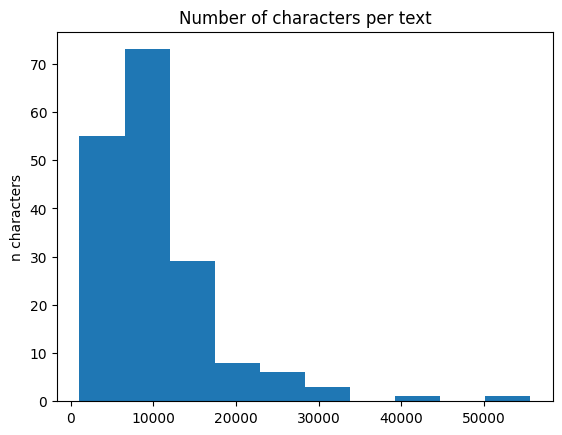

In [14]:
# There is a limit of how many characters can eb treated in a prompt. For Chatgpt-4o it's 10.000 (for Chatgpt-4 it seems substantially higher)
# Inspect the distribution of character numbers for the text. Keep in mind that before the text, some instructions to Chatgpt will be added.
texts_ncharacters = [len(data.loc[idx, 'text']) for idx in data.index]
plt.figure()
plt.hist(texts_ncharacters)
plt.title('Number of characters per text')
plt.ylabel('n characters')
plt.show()

In [42]:
# Maximum length of a text for a given patient - if longer, will be split into pieces of this size, with some overlap for each piece, and the result merged
max_length_text = 5000
overlap = 0.2

# API configuration
API_URL = "https://api.generative.engine.capgemini.com/v1/llm/invoke"
API_KEY = "r0cm2NBCgk3MfaPEAz2I2a5T00pMC7ty5avqFrSf"   # Put your API key here
headers = {
    "Content-Type": "application/json",
    "Accept": "application/json",
    "x-api-key": API_KEY
}

def shorten_text(text, max_length):
    if len(text) <= max_length:
        return text
    return text[:max_length-3] + "..."

def classify_text(text, target_feature, model_name):

    if target_feature == 'atcd.endo':
        base_prompt = """Le texte suivant vient d'une patiente potentiellement atteinte d'endométriose. Je voudrais savoir si le texte donne de l'information si cette patiente a déjà eu de l'endométriose dans le passé.
        Classifiez le texte suivant concernant les antécédents d'endométriose du patient dans l'une de ces trois catégories:
    oui: Antécédent d'endométriose confirmé
    non: Pas d'antécédent d'endométriose
    ambigue: Information insuffisante

    Répondez avec la catégorie correspondante (oui, non ou ambigue) suivie d'une brève justification de votre choix. Dans votre justification, citez la ou les parties spécifiques du texte sur lesquelles vous basez votre décision. Utilisez le format suivant:
    Classification: [votre classification]
    Justification: [votre justification, incluant des citations pertinentes du texte]

    Attention: Le fait que le mot 'endométriose' apparaît dans le texte n'est pas une raison suffisante pour déduire un antécédent d'endométriose. Il faut que ce soit explicitement spécifié. Pareil si des symptômes typiques d'endométriose sont mentionnés, ce n'est pas suffisant.
    Note: Les informations suivant 'Histo', 'Historique' ou équivalent peuvent être très importante dans la décision de classification.
    Texte de la patiente : """

    elif target_feature == 'irm.lusg':
        base_prompt = """Le texte suivant vient d'une patiente. Je voudrais savoir si le texte mentionne explicitement qu'un examen IRM a identifié une lésion du ligament utéro-sacré gauche (souvent abrégé LUSG, lus g ou similaire).
    Dans un premier temps, prends toutes les parties de textes qui correspondent à des résultats d'IRM. Ignore tous le reste, y compris les chirurgies, autres imagerie comme rectosonographie, echographie etc.
    Ensuite, parmi ces parties de texte: 
    Classifiez le texte suivant dans l'une de ces trois catégories:
    oui: Une lésion/une atteinte/un nodule ou un "épaississement" du LUS gauche ou des deux LUS ou une partie, même s'il s'agit d'un doute ou possibilité, est explicitement confirmée dans les résultats de l'IRM.
    non: L'absence de lésion du LUS gauche est explicitement mentionnée dans les résultats de l'IRM.
    ambigue: Toute autre situation, y compris l'absence de mention d'un examen IRM, des résultats d'IRM ne mentionnant pas explicitement le LUS gauche, ou des informations insuffisantes pour conclure.

    Règles importantes:
    1. Classifiez 'oui' UNIQUEMENT si le texte mentionne explicitement une lésion du LUS gauche identifiée SPÉCIFIQUEMENT par un examen IRM. Le terme "IRM" doit être mentionné, et pas d'autre terme, tel qu'une opération, chirurgie, résection, exploration, rectosonographie, échographie, anapath etc.). 
    Sinon classez-la comme 'ambigue'. Quelques précisions:
    - Une "atteinte", un "nodule" ou un "épaississement" comptent aussi comme lésion, même si c'est juste léger et ne constitue pas un cas d'endométriose. Si l'un de ces terme est mentionné, c'est suffisant. Il n'y a pas besoin qu'un de ces termes soit spécifiquement mentionné, tout genre de symptôme qui concerne le LUS gauche ou les deux LUS compte comme 'oui'.
    - Si c'est formulé comme "possible", "doute sur", "potentielle", etc., cela compte aussi. 
    - Si tous les deux LUS sont concernés, cela concerne aussi le LUS gauche et compte alors comme 'oui'. Attention parfois c'est pas formulé de manière très claire, par exemple parfois les médicins écrivent "des LUS". Logiquement, si le texte parle des LUS en pluriel, cela concerne aussi le LUS gauche.
    - Si une fois dans le texte il est mentionné que l'examen n'a pas trouvé de lésion du LUS gauche et à une autre partie qui oui, considère que la bonne réponse est "oui".
    2. Classifiez 'non' UNIQUEMENT si le texte mentionne explicitement soit l'absence de lésion du LUS gauche soit une absence générale d'endométriose ou de lésion dans les résultats de l'IRM (dans ce dernier cas, pas besoin que spécifiquement le LUS gauche soit mentionné). Cela peut correspondre à des formulations tel que IRM "normal", "ne trouve pas de lésion" etc.
    3. Classifiez 'ambigue' dans TOUS les autres cas, y compris:
    - Absence de mention d'un examen IRM
    - Résultats d'IRM mentionnant UN LUS mais pas lequel des deux, gauche ou droit. Par contre si tous les deux sont concernés cela compte comme 'oui', voir ci-dessus.
    - Mention d'une lésion du LUS gauche par une autre méthode que l'IRM
    - Mention d'une chirurgie ou exploration sur cette région sans résultat IRM explicite
    - Mention d'une lésion du LUS droit (ne concerne pas le LUS gauche)
    - Toute situation où il n'y a pas de mention explicite d'une lésion ou de l'absence de lésion du LUS gauche dans les résultats IRM

    Répondez avec la catégorie correspondante (oui, non ou ambigue) suivie d'une brève justification de votre choix. Dans votre justification, citez la ou les parties spécifiques du texte sur lesquelles vous basez votre décision. Utilisez le format suivant:
    Classification: [votre classification]
    Justification: [votre justification, incluant des citations pertinentes du texte]

    Rappel: Un nodule dans le LUS gauche mentionné dans les résultats IRM compte comme une lésion et devrait être classifié comme 'oui'.
    

    Texte de la patiente : """
        
    elif target_feature == 'atcd.absenteisme':
        base_prompt = """Le texte suivant vient d'une patiente potentiellement atteinte d'endométriose. Je voudrais savoir si le texte donne de l'information si cette patiente a déjà montré un absentéisme professionel ou scolaire.
        Classifiez le texte suivant dans l'une de ces trois catégories:
    oui: Patiente montre un absentéisme professionel ou scolaire. Si le texte mentionne que la patiente ne montre pas d'absentéisme, n'inférez PAS de ça que la patiente a eu un abséntisme avant SAUF si c'est explicitement mentionné dans le texte.
    non: Le texte mentionne explicitement que la patiente ne montre PAS d'absentéisme professionel ou scolaire ("pas d'absentéisme")
    ambigue: Le texte ne fait pas de mention d'absentéisme.

    Répondez avec la catégorie correspondante (oui, non ou ambigue) suivie d'une brève justification de votre choix. Dans votre justification, citez la ou les parties spécifiques du texte sur lesquelles vous basez votre décision. Utilisez le format suivant:
    Classification: [votre classification]
    Justification: [votre justification, incluant des citations pertinentes du texte]
    
    Texte de la patiente : """
        
    elif target_feature == 'tv.douloureux':
        base_prompt = """Le texte suivant vient d'une patiente potentiellement atteinte d'endométriose. Je voudrais savoir si le texte donne de l'information si cette patiente a des douleurs au toucher vaginal.
        Classifiez le texte suivant dans l'une de ces trois catégories:
    'oui': UNIQUEMENT si le texte mentionne explicitement que la patiente montre des douleurs au toucher vaginal. La présence de dyspareunies n'est pas suffisante pour déduire des des douleurs au toucher vaginal.
    'non': UNIQUEMENT si le texte mentionne explicitement que la patiente ne montre PAS de douleur au toucher vaginal. Si c'est le cas, donner la classification 'non'.
    'ambigue': Le texte ne fait pas de mention de douleurs au toucher vaginal, il y a des informations contradictoires ou il n'est pas possible de le déterminer avec certitude.
    
    Quelques remarques importantes: 
    - "Toucher vaginal" est souvent abbrévié comme "TV".
    - "Sensible" veut dire douleureux aussi.
    - Ignores d'autres termes qui ne sont pas en lien avec la douleur, comme "atteinte" ou "infiltration".
    Répondez avec la catégorie correspondante (oui, non ou ambigue) suivie d'une brève justification de votre choix. Dans votre justification, citez la ou les parties spécifiques du texte sur lesquelles vous basez votre décision. Utilisez le format suivant:
    Classification: [votre classification]
    Justification: [votre justification, incluant des citations pertinentes du texte]
    
    Texte de la patiente : """
        
    elif target_feature == 'sf.dig.diarrhee':
        base_prompt = """Le texte suivant vient d'une patiente potentiellement atteinte d'endométriose. Je voudrais savoir si le texte donne de l'information si cette patiente a la diarrhée.
        Classifiez le texte suivant dans l'une de ces trois catégories:
    'oui': UNIQUEMENT si le texte mentionne explicitement que la patiente a la 'diarrhée', avec la mention de ce terme concrètement.
    'non': UNIQUEMENT si le texte mentionne explicitement que la patiente ne montre PAS pas de trouble digestif ou pas de diarrhé en spécifique. La présence de constipation n'implique pas forcément l'absence de diarrhés.
    'ambigue': DANS TOUS LES AUTRES CAS, ca veut dire par exemple: Le texte ne fait pas de mention de diarrhée, il y a des informations contradictoires ou il n'est pas possible de le déterminer avec certitude.
    
    Répondez avec la catégorie correspondante (oui, non ou ambigue) suivie d'une brève justification de votre choix. Dans votre justification, citez la ou les parties spécifiques du texte sur lesquelles vous basez votre décision. Utilisez le format suivant:
    Classification: [votre classification]
    Justification: [votre justification, incluant des citations pertinentes du texte]
    
    Texte de la patiente : """
    
    prompt = base_prompt + text + "\n\nRéponse:"
    print(f'Number of prompt characters: {len(prompt)}')

    payload = {
        "action": "run",
        "modelInterface": "langchain",
        "data": {
            "mode": "chain",
            "text": prompt,
            "files": [],
            "modelName": model_name,
            "provider": "azure",
            "modelKwargs": {
                "maxTokens": 250,  # Increased to allow for longer justifications with citations
                "temperature": 0.1,
                "streaming": False,
                "topP": 0.9
            }
        }
    }

    try:
        response = requests.post(API_URL, headers=headers, json=payload)
        if response.status_code == 200:
            for line in response.text.split('\n'):
                if line.startswith('data: '):
                    try:
                        json_data = json.loads(line[6:])  # Remove 'data: ' prefix
                        if json_data['action'] == 'final_response':
                            content = json_data['data']['content']
                            # Parse the content to extract classification and justification
                            lines = content.strip().split('\n')
                            classification = lines[0].split(': ')[1].strip().lower()
                            justification = ' '.join(lines[1:]).split(': ', 1)[1].strip()
                            return classification, justification
                    except json.JSONDecodeError:
                        continue
            print('No valid response found in the data')
        else:
            print(f'Error: {response.status_code} - {response.text}')
    except requests.RequestException as e:
        print(f'An error occurred: {e}')
    
    return None, None

def classify_patient(txt, target_feature, model_name=model_name, max_length_text=max_length_text, overlap=overlap):
    len_txt = len(txt)
    if model_name!='openai.gpt-4o' or (len_txt <= max_length_text):
        # Sometimes, the request can time out. repeat until it works, but try maximum 5 times
        classification = None
        itry=0
        while (classification==None) and (itry < 5):
            if itry>0: print(f'Attempt {itry+1}...')
            classification, justification = classify_text(txt, target_feature, model_name=model_name)
            itry += 1
    # For gpt-4o, if the text is longer than 5000 characters long, split it into several pieces and merge the outputs for the different texts
    else:
        print(f'Text has too many characters ({len_txt}) - cutting into several parts...')
        classifications_text_parts = []
        justifications_text_parts = []
        idx_char_start = 0
        idx_char_end = idx_char_start + max_length_text
        part_text = 1
        while idx_char_end <= len_txt:
            print(f'## Part {part_text}')
            print(f'Taking sub-text from character {idx_char_start} to {idx_char_end}')
            text_part = txt[idx_char_start:idx_char_end]
            classification_text_part = None
            itry=0
            while (classification_text_part==None) and (itry < 5):
                if itry>0: print(f'Attempt {itry+1}...')
                classification_text_part, justification_text_part = classify_text(text_part, target_feature, model_name=model_name)
                itry += 1
            # If any part of the text gives classification 'oui', take this as a classification for the whole text and stop
            if classification_text_part == 'oui':
                classification = classification_text_part
                justification = justification_text_part
                print('Found evidence for classification <oui>, early stopping.')
                break
            else:
                classification = 'to_be_determined'
                justification = 'to_be_determined'
            classifications_text_parts = classifications_text_parts + [classification_text_part]
            justifications_text_parts = justifications_text_parts + [justification_text_part]
            part_text += 1
            idx_char_start = idx_char_start + int(max_length_text*(1-overlap))
            if idx_char_end == len_txt:
                break
            elif (idx_char_start + max_length_text) > len_txt:
                idx_char_start = len_txt - max_length_text
            idx_char_end = idx_char_start + max_length_text
        
        if classification != 'oui':
            
            # Ignore the parts for which the call failed (should not happen often, else there is an issue with the API connectivity)
            justifications_text_parts = [j for j in justifications_text_parts if j is not None]
            classifications_text_parts = [c for c in classifications_text_parts if c is not None]

            # If there is at least one classification as 'no', this is sufficient to classify the whole text as 'no'. 
            # (Assuming the model found an explicit mention of the absence of the symptom for example, and given that there was no classification as 'oui')
            if 'non' in classifications_text_parts:
                classification = 'non'
                i=0
                while i < len(classifications_text_parts):
                    if classifications_text_parts[i] == 'non':
                        justification = justifications_text_parts[i]
                        break
                    i += 1
            else:
                classification = 'ambigue'
                justification = " ".join(justifications_text_parts)

    return classification, justification

In [43]:
### RECOMMENDED: Take only a sub-part of all the patients, since the number of calls to the API is limited
# Will take equal number of patients per condition (so best to choose number divisible by 3)
npatients_to_include = 60
data_orig = data.copy()

if npatients_to_include != 'all':
    if data.loc[data[target_feature]==0].shape[0] >= int(npatients_to_include/3):
        data_no = data.loc[data[target_feature]==0].sample(int(npatients_to_include/3), random_state=1)
    else:
        data_no = data.loc[data[target_feature]==0]

    if data.loc[data[target_feature]==1].shape[0] >= int(npatients_to_include/3):
        data_yes = data.loc[data[target_feature]==1].sample(int(npatients_to_include/3), random_state=1)
    else:
        data_yes = data.loc[data[target_feature]==1]

    if data.loc[data[target_feature]==2].shape[0] >= int(npatients_to_include/3):
        data_ambiguous = data.loc[data[target_feature]==2].sample(int(npatients_to_include/3), random_state=1)
    else:
        data_ambiguous = data.loc[data[target_feature]==2]

    data = pd.concat([data_no, data_yes, data_ambiguous])
    data.reset_index(inplace=True, drop=True)

In [44]:
### Classify each text
classifications = []
justifications = []
nfails = 0
for index, row in data.iterrows():
    print(f"##### Classifying patient {index + 1}/{len(data)} #####")
    
    txt = row['text']
    classification, justification = classify_patient(txt, target_feature, model_name=model_name)
    
    if classification==None:
        print('!! Call to API failed despite 5 attempts !!')
        nfails += 1
        print(f'So far, call to API failed for {nfails} out of {len(data)} texts')
    classifications.append(classification)
    justifications.append(justification)
    time.sleep(1)  # Add a delay to avoid hitting rate limits

# Add classifications and justifications to the dataset
data['api_classification'] = classifications
data['justification'] = justifications

print("Classification complete.")
data

##### Classifying patient 1/48 #####
Number of prompt characters: 6210
##### Classifying patient 2/48 #####
Text has too many characters (10313) - cutting into several parts...
## Part 1
Taking sub-text from character 0 to 5000
Number of prompt characters: 6284
Found evidence for classification <oui>, early stopping.
##### Classifying patient 3/48 #####
Text has too many characters (5266) - cutting into several parts...
## Part 1
Taking sub-text from character 0 to 5000
Number of prompt characters: 6284
## Part 2
Taking sub-text from character 266 to 5266
Number of prompt characters: 6284
##### Classifying patient 4/48 #####
Text has too many characters (7058) - cutting into several parts...
## Part 1
Taking sub-text from character 0 to 5000
Number of prompt characters: 6284
## Part 2
Taking sub-text from character 2058 to 7058
Number of prompt characters: 6284
##### Classifying patient 5/48 #####
Text has too many characters (5689) - cutting into several parts...
## Part 1
Taking sub-

,patient,text,atcd.endo,api_classification,justification
0,GM-160,leeloo en continu oar 6 mois irm pelvienne...,0.0,ambigue,Le texte mentionne plusieurs examens et symptô...
1,GS-193,endométriose coelioscopie destruction et o...,0.0,oui,"Le texte mentionne explicitement ""lésions d'en..."
2,LC-096,non recherché non prise en charge de la doul...,0.0,ambigue,Le texte mentionne plusieurs éléments relatifs...
3,MM-133,suivi docteur fevre anne reims depuis juille...,0.0,ambigue,Le texte mentionne plusieurs symptômes et exam...
4,RC-141,c cochet patiente de 41 ans g0 pas de désir ...,0.0,oui,"Le texte mentionne explicitement ""diagnostic d..."
5,SL-041,minidril 1 pilule j sans arrêt entre les pl...,0.0,ambigue,Le texte mentionne plusieurs éléments liés à l...
6,SM-138,neuro docteur obadia andre mt docteur déni...,0.0,oui,Le texte mentionne explicitement plusieurs ant...
7,VM-081,coelio explo avec probable résection us g tr ...,0.0,oui,Le texte mentionne explicitement des antécéden...
8,VC-068,22 ans g5p1 1 cesar pe 29sa 2 fcs 1 ga 2019 ...,1.0,oui,"Le texte mentionne explicitement ""endométriose..."
9,HF-202,cs docteur glachant tentative de gs depuis 4...,1.0,oui,Le texte mentionne explicitement que la patien...


In [45]:
data_results = data.copy()
data_results.dropna(inplace=True)
data_results[target_feature] = data_results[target_feature].replace({np.nan: 2})
data_results['api_classification'] = data_results['api_classification'].replace({'non': 0, 'oui': 1, 'ambigue': 2})
data_results[target_feature] = data_results[target_feature].astype(int)
data_results['api_classification'] = data_results['api_classification'].astype(int)
data_results

/tmp/ipykernel_2395/1450562257.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_results['api_classification'] = data_results['api_classification'].replace({'non': 0, 'oui': 1, 'ambigue': 2})


,patient,text,atcd.endo,api_classification,justification
0,GM-160,leeloo en continu oar 6 mois irm pelvienne...,0,2,Le texte mentionne plusieurs examens et symptô...
1,GS-193,endométriose coelioscopie destruction et o...,0,1,"Le texte mentionne explicitement ""lésions d'en..."
2,LC-096,non recherché non prise en charge de la doul...,0,2,Le texte mentionne plusieurs éléments relatifs...
3,MM-133,suivi docteur fevre anne reims depuis juille...,0,2,Le texte mentionne plusieurs symptômes et exam...
4,RC-141,c cochet patiente de 41 ans g0 pas de désir ...,0,1,"Le texte mentionne explicitement ""diagnostic d..."
5,SL-041,minidril 1 pilule j sans arrêt entre les pl...,0,2,Le texte mentionne plusieurs éléments liés à l...
6,SM-138,neuro docteur obadia andre mt docteur déni...,0,1,Le texte mentionne explicitement plusieurs ant...
7,VM-081,coelio explo avec probable résection us g tr ...,0,1,Le texte mentionne explicitement des antécéden...
8,VC-068,22 ans g5p1 1 cesar pe 29sa 2 fcs 1 ga 2019 ...,1,1,"Le texte mentionne explicitement ""endométriose..."
9,HF-202,cs docteur glachant tentative de gs depuis 4...,1,1,Le texte mentionne explicitement que la patien...


In [46]:
print(classification_report(data_results[target_feature], data_results['api_classification']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.53      1.00      0.69        20
           2       0.20      0.05      0.08        20

    accuracy                           0.44        48
   macro avg       0.24      0.35      0.26        48
weighted avg       0.30      0.44      0.32        48



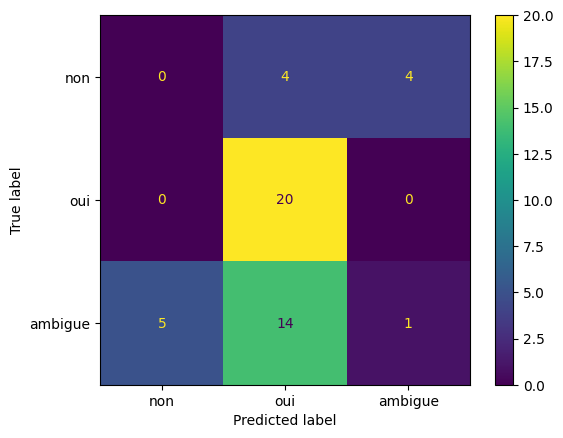

In [47]:
cm = confusion_matrix(data_results[target_feature], data_results['api_classification'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non', 'oui', 'ambigue'])
disp.plot()

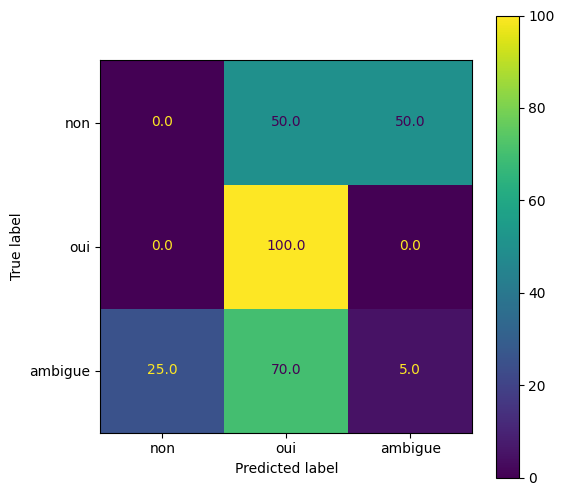

In [48]:
# Confusion matrix with percentages
cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100  # Normalize by row (per class) percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=['non', 'oui', 'ambigue'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='viridis', ax=ax, values_format=".1f")  # Format to 1 decimal place
plt.show()

Investigate misclassifications

In [49]:
data_results.loc[(data_results[target_feature]==0) & (data_results['api_classification']==2)]

,patient,text,atcd.endo,api_classification,justification
0,GM-160,leeloo en continu oar 6 mois irm pelvienne...,0,2,Le texte mentionne plusieurs examens et symptô...
2,LC-096,non recherché non prise en charge de la doul...,0,2,Le texte mentionne plusieurs éléments relatifs...
3,MM-133,suivi docteur fevre anne reims depuis juille...,0,2,Le texte mentionne plusieurs symptômes et exam...
5,SL-041,minidril 1 pilule j sans arrêt entre les pl...,0,2,Le texte mentionne plusieurs éléments liés à l...


In [50]:
# Show decision for specific patient (you can play with the prompt to see if it changes the classification)
patient = 'CA-114' #GM-160
data.loc[data.patient==patient, 'text'].head(2)
text_series = data.loc[data.patient == patient, 'text']
text_list = text_series.tolist()  # Convert the Series to a list

# Combine the list into a single string if the function expects a single text input
text_combined = " ".join(text_list)

# Now use the combined text in the classify_patient function
classification_text, justification_text = classify_patient(text_combined, target_feature, model_name=model_name)
#classification_text, justification_text = classify_patient(data.loc[data.patient==patient, 'text'], target_feature, model_name=model_name) #.values[0]

print(classification_text)
print(justification_text)

Number of prompt characters: 1284


IndexError: list index out of range